# Intoduction:

## Books Recommendation
In this Notebook I have created a Books Recommendation Sysytem

* My linkedin id : [Saurabh Maulekhi](https://www.linkedin.com/in/saurabh-maulekhi-326584241/)
* [Model Web Deployment](https://huggingface.co/spaces/saurabh091/LLM_and_Similarity_Based_Media_Recommendation_System)
* [Github Repo](https://github.com/Saurabh-Maulekhi/LLM-and-Similarity-Based-Media-Recommendation-System)
* [Music Recommendation Deployment](https://www.kaggle.com/code/saurabhmaulekhi/music-recommendation)
* [Movies Recommendation Deployment](https://www.kaggle.com/code/saurabhmaulekhi/movie-recommendation-system)

# Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import pickle

# Data Cleaning

## Getting Data

In [ ]:
books = pd.read_csv('/kaggle/input/book-recommendation-dataset/Books.csv')
users = pd.read_csv('/kaggle/input/book-recommendation-dataset/Users.csv')
ratings = pd.read_csv('/kaggle/input/book-recommendation-dataset/Ratings.csv')

In [ ]:
books.head()

In [ ]:
ratings.head()

In [ ]:
print(books.shape)
print(users.shape)
print(ratings.shape)

In [ ]:
books.isnull().sum()

In [ ]:
users.isnull().sum()

In [ ]:
ratings.isnull().sum()

In [ ]:
books.duplicated().sum()

In [ ]:
ratings.duplicated().sum()

## Popularity Based Recommender System

In [ ]:
### Merging ratings and merge dataframe

ratings_with_name = ratings.merge(books, on='ISBN')

In [ ]:
ratings_with_name.head()

In [ ]:
ratings_with_name.info()

In [ ]:
# creating a dataframe for books and the counting number of ratings it has

num_rating_df = ratings_with_name.groupby('Book-Title').count()['Book-Rating'].reset_index()
num_rating_df.rename(columns={'Book-Rating':'num_ratings'}, inplace=True)
num_rating_df.head()

In [ ]:
# creating a dataframe for books and the average of rating it has

avg_rating_df = (
    ratings_with_name.groupby('Book-Title')['Book-Rating']
    .mean()
    .reset_index()
)
avg_rating_df.rename(columns={'Book-Rating': 'avg_rating'}, inplace=True)

avg_rating_df.head()

In [ ]:
## meriging num_rating_df and avg_rating_df

popular_df = num_rating_df.merge(avg_rating_df, on="Book-Title")
popular_df

In [ ]:
## getting books where number of rating is greater or equal than 250 and sorting values in descending order 
popular_df = popular_df[popular_df["num_ratings"]>=250].sort_values('avg_rating', ascending=False).head(100)

In [ ]:
## Merging popular_df and books dataframe on basis of comman column "Book-Title" and drop duplicates in "Book-Title"
## retriving ['Book-Title', 'Book-Author', 'Image-URL-M','num_ratings','avg_rating'] columns from merged dataframe

popular_df = popular_df.merge(books, on="Book-Title").drop_duplicates('Book-Title')[['Book-Title', 'Book-Author', 'Image-URL-M','num_ratings','avg_rating']]

In [ ]:
# This is our DataFrame having Popular Books in from our data
popular_df.head()

In [ ]:
popular_df['Image-URL-M'][0]

## Collaborative Filtering Based Recommender System

In [ ]:
## Getting the User-ID of Users who has rated more than 200 books
x = ratings_with_name.groupby("User-ID").count()['Book-Rating'] > 200
experienced_users = x[x].index

In [ ]:
# getting details of books which are rated by our experinced book

filtered_ratings = ratings_with_name[ratings_with_name['User-ID'].isin(experienced_users)]

In [ ]:
## Books which have atleast 50 ratings done by user on them
y = filtered_ratings.groupby('Book-Title').count()['Book-Rating']>=50
famous_books = y[y].index

In [ ]:
final_ratings = filtered_ratings[filtered_ratings['Book-Title'].isin(famous_books)]

In [ ]:
final_ratings

In [ ]:
## Making pivot table
pt = final_ratings.pivot_table(index='Book-Title', columns='User-ID', values='Book-Rating')

In [ ]:
pt.fillna(-1, inplace=True)

In [ ]:
pt

# Cosine Similarity 

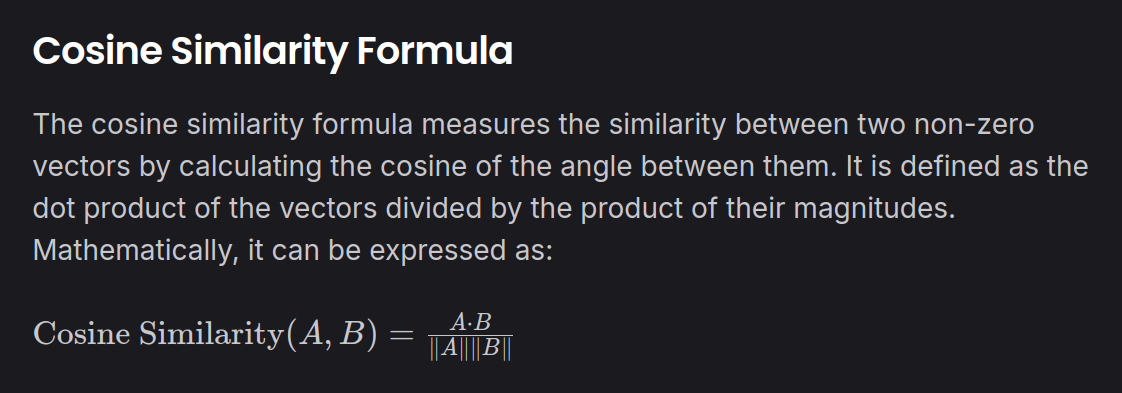

**more simillar score = more similar similar vectors in the plane**



* **Now we Can think of our Books as a vector of 810 dimensions**
  > since our book is a vector we can find similarity between the books

In [ ]:
# Using cosine similarity for book's vectors
# Creating a matrix which haver similarity score between Books
similarity_scores = cosine_similarity(pt)

In [ ]:
similarity_scores.shape

# Books Recommendation Function

In [ ]:
def recommend(book_name):
    # index fetch
    index = np.where(pt.index==book_name)[0][0] ## Getiing the movie's index 

    # fisrt creating a list of tuples , tuple = (<index> , similarity score)
    # sorting tuples list in desceding order of similarity order
    # third getting index values from index of list 1 to 10[including 10] and storing them in a list . We are not including 0th index because this is the score of highest similarity of books with itself , 
    similar_items = sorted(list(enumerate(similarity_scores[index])), key=lambda x:x[1], reverse=True)[1:11]

    data = [] # list containing details of multiple books
    for i in similar_items:
        item =[] # this list have book's details
        
        temp_df = books[books['Book-Title'] == pt.index[i[0]]] # temp dataframe only have one book's detail
        item.extend(list(temp_df.drop_duplicates('Book-Title')['Book-Title'].values)) 
        item.extend(list(temp_df.drop_duplicates('Book-Title')['Book-Author'].values))
        item.extend(list(temp_df.drop_duplicates('Book-Title')['Image-URL-M'].values))

        data.append(item)
    return data

In [ ]:
recommend('Four Blind Mice')

# Dumping the Popular Books Dataset and Similarity Scores

In [ ]:
pickle.dump(popular_df, open('popular.pkl', 'wb'))

In [ ]:
popular_df.head()

In [ ]:
pickle.dump(pt, open('pt.pkl', 'wb'))
pickle.dump(books, open('books.pkl', 'wb'))
pickle.dump(similarity_scores,open('similarity_score.pkl','wb'))